# Affective-EC

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../30_Code/")

In [3]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from itertools import islice, filterfalse

In [4]:
import Fusiform

## Data Import

In [6]:
rs = np.random.RandomState(2254)
afflex_path = Fusiform.get_data_path('lexicon', 'afflex.csv')
afflex = pd.read_csv(afflex_path, index_col=0)
afflex = afflex.loc[rs.rand(afflex.shape[0])<1, :]
afflex["lemmalen"] = afflex.index.str.len()
afflex = afflex.sort_values("lemmalen").drop("lemmalen", axis=1)
afflex.head()

,IsHappy,IsSad,IsFear,IsAnger,IsSurprise,IsPositive,IsNegative,IsNeutral,IsComplex
lemma,,,,,,,,,
從,1,0,0,0,0,1,0,0,0
暴,0,0,0,1,0,0,1,0,0
豬,0,0,0,1,0,0,1,0,0
跪,0,1,0,0,0,0,1,0,0
嚷,0,0,0,1,0,0,1,0,0


In [7]:
cv_path = Fusiform.get_data_path("", "charac_coeff.pkl")
with open(cv_path, "rb") as fin:
    cv_itos, cv_stoi, cv_vectors = pickle.load(fin)
char_space50 = Fusiform.CharacterSpace(cv_itos, cv_stoi, cv_vectors, n_components=50)

In [8]:
from itertools import chain
uniq_affchars = set(chain.from_iterable(x for x in afflex.index))
n_missed = sum(1 for x in uniq_affchars if x not in char_space50.stoi)
print(f"OOV: {n_missed}/{len(uniq_affchars)} = {n_missed/len(uniq_affchars)*100:#.2f}%")

OOV: 119/3078 = 3.87%


## Prepare dataset

In [9]:
aff_ds = Fusiform.AffectiveDataset(char_space50, afflex)
print(f'aff_ds N:{len(aff_ds)}')

aff_ds N:10032


In [10]:
loader = DataLoader(aff_ds, batch_size=2, collate_fn=Fusiform.dataset.collate_fn)

In [11]:
aff_ds[1][0].shape

torch.Size([1, 50])

In [12]:
xx, yy = next(iter(loader))
print(xx.shape)
print(yy.shape)

torch.Size([2, 1, 50])
torch.Size([2, 5])


## Build NN model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
USE_CUDA = True
if torch.cuda.is_available() and USE_CUDA:    
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [13]:
feat_dim = xx.shape[-1]
hidden_dim = 100
out_dim = yy.shape[-1]

In [33]:
loader = DataLoader(aff_ds, batch_size=100, collate_fn=Fusiform.dataset.collate_fn)
model = Fusiform.AffectiveEcModel(feat_dim, hidden_dim, out_dim)
adam = optim.Adam(model.parameters(), lr=0.005)
model.to(device)
loss_vec = []
acc_vec = []
recall_vec = []
prec_vec = []

In [36]:
n_epoch = 100
for _ in tqdm(range(n_epoch)):
    loss_epoch = []
    acc_epoch = []
    recall_epoch = []
    prec_epoch = []
    # loader_iter = islice(loader, 100)    
    loader_iter = iter(loader)
    for xx, yy in loader_iter:
        xx = xx.to(device)
        yy = yy.to(device)
        ypred = model(xx)
        loss = F.binary_cross_entropy(ypred, yy.float(), reduction='sum')

        adam.zero_grad()
        loss.backward()
        loss_epoch.append(loss.item())
        acc = torch.eq(ypred > 0.5, yy==1.).sum().float() / yy.numel()
        acc_epoch.append(acc.item())
        recall = ((ypred>0.5).float() * yy).sum().float() / yy.sum()
        recall_epoch.append(recall.item())
        prec = ((ypred<0.5).float() * (1-yy)).sum().float() / (1-yy).sum()
        prec_epoch.append(prec.item())
        adam.step()
    loss_vec.append(np.mean(loss_epoch))
    acc_vec.append(np.mean(acc_epoch))
    recall_vec.append(np.nanmean(recall_epoch))
    prec_vec.append(np.nanmean(prec_epoch))

Text(0.5,1,'Precision')

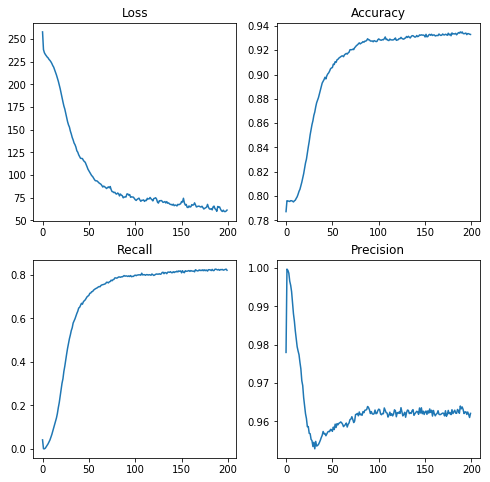

In [37]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((8,8))
axes[0][0].plot(loss_vec)
axes[0][0].set_title('Loss')
axes[0][1].plot(acc_vec)
axes[0,1].set_title('Accuracy')
axes[1,0].plot(recall_vec)
axes[1,0].set_title('Recall')
axes[1,1].plot(prec_vec)
axes[1,1].set_title('Precision')

In [38]:
model_path = Fusiform.get_data_path("nnmodel", "nnmodel.H100.pt")
torch.save(model.state_dict(), model_path)

In [40]:
model_diag_path = Fusiform.get_data_path("nnmodel", "nnmodel.H100.diag.pt")
torch.save({"loss": loss_vec, "accuracy": acc_vec,
           "recall": recall_vec, "precision": prec_vec}, model_diag_path)

## Model Evaluation

In [17]:
feat_dim = xx.shape[-1]
hidden_dim = 100
out_dim = yy.shape[-1]

In [18]:
model_path = Fusiform.get_data_path("nnmodel", "nnmodel.H100.pt")
if model_path.exists():
    model = Fusiform.AffectiveEcModel(feat_dim, hidden_dim, out_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()

In [21]:
predictor = Fusiform.AffectiveEcPredictor(model, char_space50)

In [43]:
afflex.shape

(14283, 9)

In [84]:
test_lemmas = ["藍瘦香菇", "欣喜若狂", "快樂", "享樂", "享受", 
               "盛怒", "盛恕", "爆怒", "唬爛", "畫唬爛", "流言", 
               "中立", "台北", "台中", "高雄", "八卦"]
for lemma_x in test_lemmas:
    preds = predictor.predict_class(lemma_x)
    print(f"{lemma_x}, in train: {lemma_x in afflex.index} => {preds}")

藍瘦香菇, in train: False => ['Happy', 'Sad']
欣喜若狂, in train: True => ['Happy']
快樂, in train: True => ['Happy']
享樂, in train: True => ['Happy']
享受, in train: True => ['Happy']
盛怒, in train: True => ['Anger']
盛恕, in train: False => ['Anger']
爆怒, in train: False => ['Anger']
唬爛, in train: True => ['Anger']
畫唬爛, in train: False => ['Sad']
流言, in train: False => []
中立, in train: False => ['Anger']
台北, in train: False => ['Happy']
台中, in train: False => ['Happy']
高雄, in train: False => ['Happy']
八卦, in train: True => ['Anger']


In [91]:
txt = """今天在車上睡被上車的外勞大嗓門吵醒
一怒之下唱了陳淑樺&羅大佑的滾滾紅塵
"""

In [92]:
ug = []
bg = []
tg = []
qg = []

for i in range(len(txt)):
    ug.append(predictor.predict(txt[i:i+1]))
    bg.append(predictor.predict(txt[i:i+2]))
    tg.append(predictor.predict(txt[i:i+3]))
    qg.append(predictor.predict(txt[i:i+4]))
    

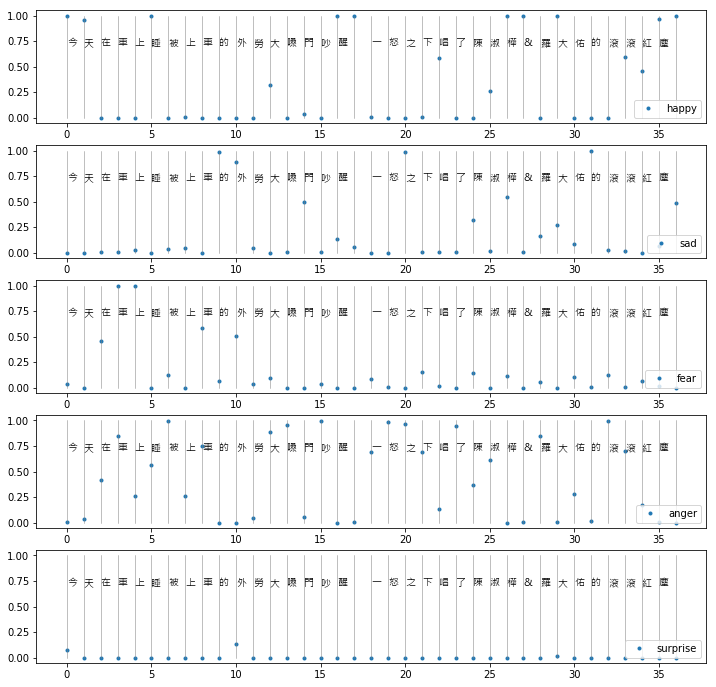

In [105]:
from matplotlib import font_manager as fm

def plot_class(seq, text, class_idx, label, ax=None):
    if not ax:
        ax = plt.gca()
    ax.plot([x[class_idx] for x in seq], '.', label=label)
    prop = fm.FontProperties(fname='C:/Windows/Fonts/msjh.ttc')
    for ti, tt in enumerate(text):
        ax.text(ti, 0.7, tt, fontproperties=prop)
        ax.plot([ti, ti], [0, 1], color='gray', linewidth=0.5)
    ax.legend(loc='lower right')
fig, axes = plt.subplots(5, 1, figsize=(12,12))
plot_class(bg, txt, 0, "happy", ax=axes[0])
plot_class(bg, txt, 1, "sad", ax=axes[1])
plot_class(bg, txt, 2, "fear", ax=axes[2])
plot_class(bg, txt, 3, "anger", ax=axes[3])
plot_class(bg, txt, 4, "surprise", ax=axes[4])

In [106]:
model

AffectiveEcModel(
  (rnn): GRU(50, 100, batch_first=True)
  (h2o): Linear(in_features=100, out_features=5, bias=True)
)